In [1]:
###转换tfrecord
import os
import tensorflow as tf 
import gc
import cv2
import numpy as np
import datetime
def get_time():
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


image_dir = "input/images"
train_dict = {}
val_dict = {}
test_dict = {}
label_list=[]

for label_dir in os.listdir(image_dir):
    class_path = os.path.join(image_dir,label_dir)
    filenames_path = [ image_dir+'/'+label_dir+'/'+filename for filename  in os.listdir(class_path)]
    train_dict[label_dir]=filenames_path[:int(0.8*len(filenames_path))]
    val_dict[label_dir]=filenames_path[int(0.8*len(filenames_path)):int(0.9*len(filenames_path))]
    test_dict[label_dir]=filenames_path[int(0.9*len(filenames_path)):]
    label_list.append(label_dir)

    

ImportError: Traceback (most recent call last):
  File "d:\python\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "d:\python\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "d:\python\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "d:\python\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "d:\python\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: 找不到指定的模块。


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
##利用图片随机删除和图片增强使样本集平衡到每个品种400个样本图片

import pandas as pd
import random

from  utils.augmentation import *

image_dir = "input/images_aug"
balance_sample_n = 400
for label_dir in os.listdir(image_dir):
    class_path = os.path.join(image_dir,label_dir)
    filenames_path = [ image_dir+'/'+label_dir+'/'+filename for filename  in os.listdir(class_path)]
    file_num=len(filenames_path)
    print(label_dir,file_num)
    if file_num>=balance_sample_n:
        random.shuffle(filenames_path)
        dropfiles = filenames_path[balance_sample_n:]
        for i in dropfiles:
            os.remove(i)
    elif file_num<balance_sample_n:
        fill_num = 400-file_num
        fill_times = int(fill_num/file_num) #每一张图片可以数据增强5份
        if fill_times==0:
            for j in range(fill_num):
                result = img_augmentation(filenames_path[j],1)
                if result == 0 :
                    continue
        if fill_times>0:
            for filename in filenames_path:
                result = img_augmentation(filename,fill_times)
                if result == 0 :
                    continue

    

In [11]:
sorted(pd_dict.items(), key=lambda x: x[1])

[('York Chocolate', 1),
 ('Chinchilla', 3),
 ('Canadian Hairless', 4),
 ('Burmilla', 8),
 ('Cymric', 17),
 ('LaPerm', 17),
 ('American Wirehair', 19),
 ('Singapura', 22),
 ('Chausie', 24),
 ('Javanese', 25),
 ('Somali', 35),
 ('Oriental Long Hair', 37),
 ('Korat', 68),
 ('Selkirk Rex', 77),
 ('Chartreux', 84),
 ('Silver', 94),
 ('Oriental Tabby', 101),
 ('Pixiebob', 111),
 ('Ocicat', 118),
 ('Devon Rex', 119),
 ('Japanese Bobtail', 127),
 ('Ragamuffin', 134),
 ('Applehead Siamese', 135),
 ('Nebelung', 148),
 ('American Curl', 149),
 ('Cornish Rex', 171),
 ('Munchkin', 181),
 ('Havana', 184),
 ('Siberian', 189),
 ('Sphynx - Hairless Cat', 209),
 ('Birman', 227),
 ('Balinese', 254),
 ('Abyssinian', 255),
 ('Tonkinese', 260),
 ('Egyptian Mau', 305),
 ('Burmese', 344),
 ('Scottish Fold', 380),
 ('Exotic Shorthair', 471),
 ('Oriental Short Hair', 491),
 ('British Shorthair', 567),
 ('Norwegian Forest Cat', 580),
 ('Turkish Angora', 750),
 ('Turkish Van', 815),
 ('American Bobtail', 991),
 (

### To tfrecord

In [ ]:
def to_tfrecords(label_imgs,des_dir):
    flag = 0
    writer = None
    
    for label,images in label_imgs.items():
        for image in images:
            if flag%1000 == 0 :
                print("flag is :",flag)
                if writer:
                    writer.flush()
                    writer.close()
                tf_path = os.path.join(des_dir,"%s_%s.tfrecords" %(flag+1,flag+1000))
                print(tf_path)
                writer = tf.python_io.TFRecordWriter(tf_path)
            flag +=1
            try:
                img = cv2.imread(image)
                if  img is None:
                    print("can't recognize picture: ",image)
                    continue
            except:
                print("can't recognize picture: ",image)
                continue
            grayed_img =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            scale_img = cv2.resize(grayed_img,(250,151))
            bytes_img = scale_img.astype(np.float32).tobytes()
            label_ = label.encode("utf-8") ## one hot encoder ?
            
            example = tf.train.Example(features=tf.train.Features(feature={
                                                                           'label':tf.train.Feature(bytes_list=tf.train.BytesList(value=[label_])),
                                                                          'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(bytes_img)]))
                                                                                                } )
                                                          )
            writer.write(example.SerializeToString())
            
            del img
            del grayed_img
            del bytes_img
            del example
            gc.collect()
            writer.flush()
            
    writer.close()

image_tf_dir = "input/tfrecord/"
to_tfrecords(train_dict,image_tf_dir+"image_train_tfrcds")
# to_tfrecords(val_dict,image_tf_dir+"image_val_tfrcds")
# to_tfrecords(test_dict,image_tf_dir+"image_test_tfrcds")

### To Inception tfrecord

In [ ]:
###转换tfrecord
import os
import tensorflow as tf 
import gc
import cv2
import numpy as np

import datetime
def get_time():
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


image_dir = "input/images_aug"
train_dict = {}
val_dict = {}
test_dict = {}
label_list=[]

for label_dir in os.listdir(image_dir):
    class_path = os.path.join(image_dir,label_dir)
    filenames_path = [ image_dir+'/'+label_dir+'/'+filename for filename  in os.listdir(class_path)]
    train_dict[label_dir]=filenames_path[:int(0.8*len(filenames_path))]
    val_dict[label_dir]=filenames_path[int(0.8*len(filenames_path)):int(0.9*len(filenames_path))]
    test_dict[label_dir]=filenames_path[int(0.9*len(filenames_path)):]
    label_list.append(label_dir)

    
def unfreez(model_path,unfreez_tensor_dict):
    with tf.gfile.GFile(name=model_path, mode='rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
        g = tf.get_default_graph()
        tensors = {t: g.get_tensor_by_name(unfreez_tensor_dict[t]) for t in unfreez_tensor_dict}
        return tensors
    

def to_inception_tfrecords(label_imgs,des_dir):
    flag = 100000000
    writer = None
    model_path='model/frozen_model/inception/classify_image_graph_def.pb'
    unfreez_tensor={'input':'DecodeJpeg/contents:0',
                            'output':'pool_3:0'}
    with tf.Graph().as_default(),tf.Session().as_default() as sess:
        tensors=unfreez(model_path,unfreez_tensor)
        for label,images in label_imgs.items():
            for image in images:
                if flag%1000 == 0 :
                    print(get_time())
                    print("flag is :",flag)
                    if writer:
                        writer.flush()
                        writer.close()
                    tf_path = os.path.join(des_dir,"%s_%s.tfrecords" %(flag+1,flag+1000))
                    print(tf_path)
                    writer = tf.python_io.TFRecordWriter(tf_path)
                    
                flag +=1
                try:
                    img_raw =open(image,'rb').read()
                    if  img_raw is None:
                        print("can't open picture: ",image)
                        continue
                except:
                    print("can't recognize picture: ",image)
                    continue
                try:
                    inception_out=sess.run(tensors['output'],{tensors['input']:img_raw}).reshape(-1).tobytes()
                except:
                    print("can't compute picture: ",image)
                    continue
                label_ = label.encode("utf-8") ## one hot encoder ?

                example = tf.train.Example(features=tf.train.Features(feature={
                                                                   'label':tf.train.Feature(bytes_list=tf.train.BytesList(value=[label_])),
                                                                  'img_incept':tf.train.Feature(bytes_list=tf.train.BytesList(value=[inception_out]))
                                                                                        } )
                                                              )
                writer.write(example.SerializeToString())

                del img_raw
                del inception_out
                del example
                gc.collect()
                writer.flush()
             
    writer.close()
    print(des_dir,' written complete!')

    
image_tf_dir = "input/tfrecord/inception_data_aug/"
to_inception_tfrecords(train_dict,image_tf_dir+"image_train_tfrcds")
# to_inception_tfrecords(val_dict,image_tf_dir+"image_val_tfrcds")
# to_inception_tfrecords(test_dict,image_tf_dir+"image_test_tfrcds")

## Train

In [10]:
import os
import tensorflow as tf 
import gc
import cv2
import numpy as np
import pandas as pd
from sklearn import preprocessing as prep
import warnings
from tensorflow.contrib.layers.python.layers import initializers
from tensorflow.contrib.slim import arg_scope
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

####提取labels全集
image_dir = "input/images_aug"
label_list=[]
for label_dir in os.listdir(image_dir):
    label_list.append(label_dir)
label_list_byte = [i.encode("utf-8") for i in label_list ]

def parse_dataset(serialized_example):
    feature = {'img_incept': tf.FixedLenFeature([], tf.string),
                   'label': tf.FixedLenFeature([], tf.string)}
    features = tf.parse_single_example(serialized_example, feature)
    image = tf.decode_raw(features['img_incept'], tf.float32)
    label = tf.cast(features['label'], tf.string)
    label= tf.where(tf.equal(label_list_byte, label))[0,0]
    return image,label

#设置训练队列和batch相关
train_dir_path="input/tfrecord/inception_data_aug/image_train_tfrcds/"
train_data=tf.data.TFRecordDataset(["%s%s"%(train_dir_path,i) for i in os.listdir(train_dir_path)])
train_data=train_data.map(parse_dataset).shuffle(1000).batch(1000).repeat()
train_iterator= train_data.make_one_shot_iterator()
train_next_element=train_iterator.get_next()


##设置测试队列和batch相关
test_dir_path="input/tfrecord/inception_data/image_test_tfrcds/"
test_data=tf.data.TFRecordDataset(["%s%s"%(test_dir_path,i) for i in os.listdir(test_dir_path)])
test_data=test_data.map(parse_dataset).batch(13000) #加载所有测试图片
test_iterator= test_data.make_one_shot_iterator()
test_next_element=test_iterator.get_next()
with tf.Session() as sess:
    test_img,test_lab=sess.run(test_next_element)
    print("the test labels are: ",test_lab)
#每种取3个用作测试（因为有很多中间张量，直接2100个会内存超负荷，如果内存足够富于的情况下可以不用下面这几行）
##（其实也可以每次把2100分多批测试，然后合并测试结果）
# test_lab_index=[]
# for i in np.unique(test_lab):
#     test_lab_index=test_lab_index+list(np.where(test_lab==i)[0])
# test_img=test_img[test_lab_index]
# test_lab=test_lab[test_lab_index]

the test labels are:  [47 47 47 ... 47 47 47]


In [7]:
##搭建网络
tf.reset_default_graph()
#tf.nn.conv2d属于底层函数，仅仅用来构造卷积操作，如无必要就用tf.contrib.layers.convolution2d一次性设置整个卷积
image_batch = tf.placeholder(tf.float32,[None,2048])
label_batch = tf.placeholder(tf.int64,[None])
is_training=tf.placeholder(tf.bool)
keep_prob_incp=tf.placeholder(tf.float32)
keep_prob=tf.placeholder(tf.float32)


iteration=10
reg=1e-4
fc0=tf.layers.dropout(image_batch,keep_prob_incp,training=is_training)
fc1= tf.contrib.layers.fully_connected(
                                fc0,
                                1024,
                                weights_initializer=tf.random_normal_initializer(stddev=tf.sqrt(1/2048)),
                                #weights_initializer=tf.contrib.layers.xavier_initializer(),
                                normalizer_fn=tf.layers.batch_normalization,#正则化项就相当于对数据集进行了尺度变换和位置变换,也就不需要下面的bias了
                                normalizer_params={'training':is_training},
                                weights_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                                activation_fn=tf.nn.relu,
                                scope="fc_lay1"
                                )
fc1=tf.layers.dropout(fc1,keep_prob,training=is_training)

fc2= tf.contrib.layers.fully_connected(
                                fc1,
                                512,
                                weights_initializer=tf.random_normal_initializer(stddev=tf.sqrt(1/1024)),
                                #weights_initializer=tf.contrib.layers.xavier_initializer(),
                                normalizer_fn=tf.layers.batch_normalization,#正则化项就相当于对数据集进行了尺度变换和位置变换,也就不需要下面的bias了
                                normalizer_params={'training':is_training},
                                weights_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                                activation_fn=tf.nn.relu,
                                scope="fc_lay2"
                                )
fc2=tf.layers.dropout(fc2,keep_prob,training=is_training)

final_fully_connected = tf.contrib.layers.fully_connected(
                                fc2,
                                67,  # 120，Number of dog breeds in the ImageNet Dogs dataset
                                weights_initializer=tf.random_normal_initializer(stddev=tf.sqrt(1/1024)),
                                #weights_initializer=tf.contrib.layers.xavier_initializer(),
                                normalizer_fn=tf.layers.batch_normalization,
                                normalizer_params={'training':is_training}, 
                                weights_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                                activation_fn=tf.nn.relu,
                                scope="final_fully_connected"
                                )

#设置损失函数
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=final_fully_connected, labels=label_batch))
regularzation_loss=tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss=tf.add_n([loss]+regularzation_loss)

global_step = tf.Variable(0)

# learning_rate = tf.train.exponential_decay(
#     0.0003,
#     global_step,
#     iteration,
#     0.95,
#     staircase=True)

boundaries = [300,400]
values = [0.0003, 0.0001,0.00005]
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

learning_rate=0.0002
trainer = tf.train.AdamOptimizer(
    learning_rate, 0.9).minimize(
    loss, global_step=global_step)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
trainer = tf.group([update_ops,trainer])

prediction = tf.nn.softmax(final_fully_connected)
label_prediction=tf.argmax(prediction,axis=1)
corr_prediction=tf.equal(label_prediction,label_batch)
right_count = tf.reduce_sum(tf.cast(corr_prediction,tf.float32))
size=tf.size(label_prediction)



# trainer,loss,right_count,size,prediction=tail_net(image_batch)

In [9]:
for n in tf.get_default_graph().as_graph_def().node:
    try:
        print(tf.get_default_graph().get_tensor_by_name(n.name+':0'))
    except:
        print(n.name, "has 0 outputs")
        continue

Tensor("DecodeJpeg/contents:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(?, ?, 3), dtype=uint8)
Tensor("Cast:0", shape=(?, ?, 3), dtype=float32)
Tensor("ExpandDims/dim:0", shape=(1,), dtype=int32)
Tensor("ExpandDims:0", shape=(1, ?, ?, 3), dtype=float32)
Tensor("ResizeBilinear/size:0", shape=(2,), dtype=int32)
Tensor("ResizeBilinear:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Sub/y:0", shape=(), dtype=float32)
Tensor("Sub:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mul/y:0", shape=(), dtype=float32)
Tensor("Mul:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("conv/conv2d_params:0", shape=(3, 3, 3, 32), dtype=float32)
Tensor("conv/Conv2D:0", shape=(1, 149, 149, 32), dtype=float32)
Tensor("conv/batchnorm/beta:0", shape=(32,), dtype=float32)
Tensor("conv/batchnorm/gamma:0", shape=(32,), dtype=float32)
Tensor("conv/batchnorm/moving_mean:0", shape=(32,), dtype=float32)
Tensor("conv/batchnorm/moving_variance:0", shape=(32,), dtype=float32)
Tensor("conv/batchnorm:

Tensor("fc_lay1/batch_normalization/moving_mean/Initializer/zeros/Const:0", shape=(), dtype=float32)
Tensor("fc_lay1/batch_normalization/moving_mean/Initializer/zeros:0", shape=(1024,), dtype=float32)
Tensor("fc_lay1/batch_normalization/moving_mean:0", shape=(1024,), dtype=float32_ref)
Tensor("fc_lay1/batch_normalization/moving_mean/Assign:0", shape=(1024,), dtype=float32_ref)
Tensor("fc_lay1/batch_normalization/moving_mean/read:0", shape=(1024,), dtype=float32)
Tensor("fc_lay1/batch_normalization/moving_variance/Initializer/ones/shape_as_tensor:0", shape=(1,), dtype=int32)
Tensor("fc_lay1/batch_normalization/moving_variance/Initializer/ones/Const:0", shape=(), dtype=float32)
Tensor("fc_lay1/batch_normalization/moving_variance/Initializer/ones:0", shape=(1024,), dtype=float32)
Tensor("fc_lay1/batch_normalization/moving_variance:0", shape=(1024,), dtype=float32_ref)
Tensor("fc_lay1/batch_normalization/moving_variance/Assign:0", shape=(1024,), dtype=float32_ref)
Tensor("fc_lay1/batch_nor

In [ ]:
train_dir_path="input/tfrecord/inception_data_aug/image_train_tfrcds/"
train_data=tf.data.TFRecordDataset(["%s%s"%(train_dir_path,i) for i in os.listdir(train_dir_path)])
train_data=train_data.map(parse_dataset).shuffle(10000).batch(5000).repeat()
train_iterator= train_data.make_one_shot_iterator()
train_next_element=train_iterator.get_next()

sess=tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)



train_loss_list=[]
test_loss_list=[]
save_dir="model/save_model"

for j in range(10000):
    
    [rs,Loss,Right_count,Size]=sess.run([final_fully_connected,loss,right_count,size], feed_dict={image_batch:test_img,label_batch:test_lab,is_training:False,
                                                                        keep_prob_incp:0,keep_prob:0})
    

    #训练
    train_img,train_lab=sess.run(train_next_element)
    sess.run(trainer,feed_dict={image_batch:train_img,label_batch:train_lab,is_training:True,keep_prob_incp:0.2,keep_prob:0.5})
    [Loss1,Right_count1,Size1]=sess.run([loss,right_count,size], feed_dict={image_batch:train_img,label_batch:train_lab,is_training:False,
                                                                        keep_prob_incp:0,keep_prob:0})
    
    train_loss_list.append(Loss1)
    test_loss_list.append(Loss)
    print('right_count and size and loss : Train %s/%s,%s  Test %s/%s,%s' %(int(Right_count1),Size1,Loss1,int(Right_count),Size,Loss))
    print("第%d batch训练完毕"%j)
    
    #保存模型
    if Right_count1/Size1 >=4350/5000 and Right_count/Size >=2460/12690:
            print("Stop")
            saver = tf.train.Saver()
            saver.save(sess,save_dir+'\Cat-Reco',global_step=j)
            break

In [55]:
rs1=np.argmax(rs,axis=1)
N=0
R=0
for i in np.unique(test_lab):
    n=np.sum(test_lab==i)
    right=np.sum(rs1[np.where(test_lab==i)]==i)
    print(i,n,right)
    N+=n
    R+=right

0 26 0
1 100 0
2 15 0
3 530 0
4 2 0
5 14 0
6 26 0
7 248 1
8 23 0
9 184 0
10 57 0
11 35 0
12 1 0
13 347 162
14 1 0
15 9 0
16 3 0
17 1 0
18 18 0
19 2 0
20 12 0
21 323 41
22 316 1
23 450 102
24 549 6
25 5303 4257
26 31 0
27 48 0
28 119 0
29 19 0
30 131 0
31 13 0
32 3 0
33 7 0
34 2 0
35 142 0
36 206 0
37 19 0
38 15 0
39 58 0
40 12 0
41 4 0
42 50 0
43 11 0
44 402 0
45 12 0
46 14 0
47 267 0
48 187 0
49 38 0
50 8 0
51 289 94
52 19 0
53 10 0
54 3 0
55 163 0
56 4 0
57 21 0
58 302 0
59 226 0
60 26 0
61 340 0
62 397 12
63 75 0
64 82 0
65 319 77
66 1 0


In [47]:
rs1=np.argmax(rs,axis=1)
N=0
R=0
for i in np.unique(test_lab):
    n=np.sum(test_lab==i)
    right=np.sum(rs1[np.where(test_lab==i)]==i)
    print(i,n,right)
    N+=n
    R+=right

0 26 10
1 100 2
2 15 1
3 530 12
4 2 0
5 14 0
6 26 1
7 248 112
8 23 2
9 184 92
10 57 11
11 35 9
12 1 0
13 347 131
14 1 1
15 9 2
16 3 0
17 1 1
18 18 10
19 2 0
20 12 0
21 323 75
22 316 117
23 450 58
24 549 37
25 5303 198
26 31 0
27 48 14
28 119 3
29 19 6
30 131 64
31 13 0
32 3 0
33 7 0
34 2 0
35 142 25
36 206 6
37 19 1
38 15 7
39 58 13
40 12 0
41 4 0
42 50 3
43 11 1
44 402 238
45 12 0
46 14 1
47 267 54
48 187 89
49 38 8
50 8 0
51 289 111
52 19 1
53 10 1
54 3 0
55 163 72
56 4 0
57 21 18
58 302 48
59 226 46
60 26 5
61 340 116
62 397 254
63 75 30
64 82 27
65 319 188
66 1 1


In [48]:
N

12690

In [49]:
R

2333

In [34]:
np.argmax(rs,axis=1)

array([46, 47,  5, ..., 47,  8, 56], dtype=int64)

In [38]:
rs.shape

(12690,)

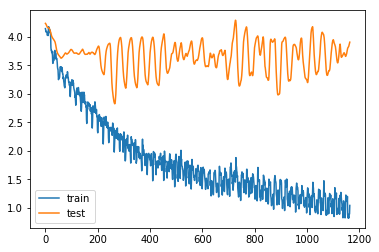

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss_list)),train_loss_list,label="train")
plt.plot(range(len(test_loss_list)),test_loss_list,label="test")
plt.legend()
plt.show()

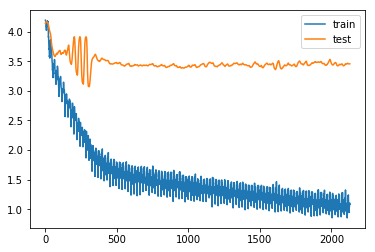

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss_list)),train_loss_list,label="train")
plt.plot(range(len(test_loss_list)),test_loss_list,label="test")
plt.legend()
plt.show()

## 冻结完整网络

#### 训练完尾巴后，重启构造完整网络，制作冻结文件

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim 
from tensorflow.python.framework import graph_util

tf.reset_default_graph()
sess=tf.Session()
model_path='model/frozen_model/inception/classify_image_graph_def.pb'
unfreez_tensor={'input':'Cast:0',
                            'output':'pool_3:0'}
def unfreez(model_path,unfreez_tensor_dict):
    with tf.gfile.GFile(name=model_path, mode='rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
        g = tf.get_default_graph()
        tensors = {t: g.get_tensor_by_name(unfreez_tensor[t]) for t in unfreez_tensor}
        return tensors    
incept_tensors=unfreez(model_path,unfreez_tensor)
image_batch=tf.squeeze(incept_tensors['output'], [0,1])

label_batch = tf.placeholder(tf.int64,[None])
is_training=tf.placeholder(tf.bool)
keep_prob_incp=tf.placeholder(tf.float32)
keep_prob=tf.placeholder(tf.float32)

iteration=10
reg=1e-4
fc0=tf.layers.dropout(image_batch,keep_prob_incp,training=is_training)
fc1= tf.contrib.layers.fully_connected(
                                fc0,
                                1024,
                                weights_initializer=tf.random_normal_initializer(stddev=tf.sqrt(1/2048)),
                                #weights_initializer=tf.contrib.layers.xavier_initializer(),
                                normalizer_fn=tf.layers.batch_normalization,#正则化项就相当于对数据集进行了尺度变换和位置变换,也就不需要下面的bias了
                                normalizer_params={'training':is_training},
                                weights_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                                activation_fn=tf.nn.relu,
                                scope="fc_lay1"
                                )
fc1=tf.layers.dropout(fc1,keep_prob,training=is_training)

fc2= tf.contrib.layers.fully_connected(
                                fc1,
                                512,
                                weights_initializer=tf.random_normal_initializer(stddev=tf.sqrt(1/1024)),
                                #weights_initializer=tf.contrib.layers.xavier_initializer(),
                                normalizer_fn=tf.layers.batch_normalization,#正则化项就相当于对数据集进行了尺度变换和位置变换,也就不需要下面的bias了
                                normalizer_params={'training':is_training},
                                weights_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                                activation_fn=tf.nn.relu,
                                scope="fc_lay2"
                                )
fc2=tf.layers.dropout(fc2,keep_prob,training=is_training)

final_fully_connected = tf.contrib.layers.fully_connected(
                                fc2,
                                67,  # 120，Number of dog breeds in the ImageNet Dogs dataset
                                weights_initializer=tf.random_normal_initializer(stddev=tf.sqrt(1/1024)),
                                #weights_initializer=tf.contrib.layers.xavier_initializer(),
                                normalizer_fn=tf.layers.batch_normalization,
                                normalizer_params={'training':is_training}, 
                                weights_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                                activation_fn=tf.nn.relu,
                                scope="final_fully_connected"
                                )

prediction = tf.nn.softmax(final_fully_connected)

In [7]:
load_v=slim.assign_from_checkpoint_fn(ignore_missing_vars=True,
                       model_path="model/save_model/Cat-Reco-5304",var_list=tf.global_variables()
                      )
load_v(sess)

INFO:tensorflow:Restoring parameters from model/save_model/Cat-Reco-5304


In [8]:
#制作freez pb
output_graph_def = graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def() , # The graph_def is used to retrieve the nodes 
            ['Softmax_1'] # The output node names are used to select the usefull nodes
        ) 

# Finally we serialize and dump the output graph to the filesystem
with tf.gfile.GFile("model/frozen_model/incp_finetuned.pb", "wb") as f:
    f.write(output_graph_def.SerializeToString())

INFO:tensorflow:Froze 15 variables.
INFO:tensorflow:Converted 15 variables to const ops.


In [14]:
import tensorflow as tf
tf.reset_default_graph()

model_path='model/frozen_model/incp_finetuned.pb'
unfreez_tensor={'input':'Cast:0',
                            'output':'pool_3:0'}
def unfreez(model_path,unfreez_tensor_dict):
    with tf.gfile.GFile(name=model_path, mode='rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
        g = tf.get_default_graph()
        tensors = {t: g.get_tensor_by_name(unfreez_tensor[t]) for t in unfreez_tensor}
        return tensors    
incept_tensors=unfreez(model_path,unfreez_tensor)

import cv2
img=cv2.imread('input/test/12136161_252.jpg')
sess=tf.Session()
sess.run(tf.get_default_graph().get_tensor_by_name('Softmax_1:0'),{incept_tensors['input']:img,
                                                                        tf.get_default_graph().get_tensor_by_name('Placeholder_1:0'):False,
                                                                        tf.get_default_graph().get_tensor_by_name('Placeholder_2:0'):0,
                                                                        tf.get_default_graph().get_tensor_by_name('Placeholder_3:0'):0,
                                                       })

array([[0.06285271, 0.00551023, 0.00551023, 0.01295281, 0.00551023,
        0.00551023, 0.00551023, 0.02146308, 0.00551023, 0.00824055,
        0.00551023, 0.00770312, 0.00551023, 0.01195515, 0.00551023,
        0.00625483, 0.00551023, 0.00551023, 0.00641844, 0.00551023,
        0.00551023, 0.01515892, 0.05474984, 0.00551023, 0.00551023,
        0.01504014, 0.01137624, 0.00551023, 0.00551023, 0.0621364 ,
        0.00551023, 0.00889353, 0.00551023, 0.01214285, 0.00551023,
        0.00551023, 0.00551023, 0.00551023, 0.00551023, 0.00551023,
        0.00743044, 0.01255634, 0.03032988, 0.00889975, 0.00551023,
        0.00551023, 0.00551023, 0.00551023, 0.00984525, 0.00551023,
        0.00551023, 0.00551023, 0.00551023, 0.00551023, 0.00551023,
        0.00668631, 0.00893075, 0.00551023, 0.00551023, 0.00551023,
        0.0090419 , 0.03281781, 0.3246934 , 0.00551023, 0.00551023,
        0.00551023, 0.00551023]], dtype=float32)

In [2]:
#制作tflite
import tensorflow as tf
convert=tf.contrib.lite.TFLiteConverter.from_frozen_graph("model/frozen_model/incp_finetuned.pb",
                                                          input_arrays=["Cast"],output_arrays=["Softmax_1"],input_shapes={"Cast":[64,64,3]} )
# convert.post_training_quantize=True
tflite_model=convert.convert()
open("model/frozen_model/incp_finetuned.tflite","wb").write(tflite_model)


RuntimeError: TOCO failed see console for info.
b'Traceback (most recent call last):\r\n  File "d:\\python\\lib\\site-packages\\tensorflow\\contrib\\lite\\toco\\python\\tensorflow_wrap_toco.py", line 18, in swig_import_helper\r\n    fp, pathname, description = imp.find_module(\'_tensorflow_wrap_toco\', [dirname(__file__)])\r\n  File "d:\\python\\lib\\imp.py", line 297, in find_module\r\n    raise ImportError(_ERR_MSG.format(name), name=name)\r\nImportError: No module named \'_tensorflow_wrap_toco\'\r\n\r\nDuring handling of the above exception, another exception occurred:\r\n\r\nTraceback (most recent call last):\r\n  File "d:\\python\\lib\\runpy.py", line 193, in _run_module_as_main\r\n    "__main__", mod_spec)\r\n  File "d:\\python\\lib\\runpy.py", line 85, in _run_code\r\n    exec(code, run_globals)\r\n  File "D:\\Python\\Scripts\\toco_from_protos.exe\\__main__.py", line 4, in <module>\r\n  File "d:\\python\\lib\\site-packages\\tensorflow\\contrib\\lite\\toco\\python\\toco_from_protos.py", line 22, in <module>\r\n    from tensorflow.contrib.lite.toco.python import tensorflow_wrap_toco\r\n  File "d:\\python\\lib\\site-packages\\tensorflow\\contrib\\lite\\toco\\python\\tensorflow_wrap_toco.py", line 28, in <module>\r\n    _tensorflow_wrap_toco = swig_import_helper()\r\n  File "d:\\python\\lib\\site-packages\\tensorflow\\contrib\\lite\\toco\\python\\tensorflow_wrap_toco.py", line 20, in swig_import_helper\r\n    import _tensorflow_wrap_toco\r\nModuleNotFoundError: No module named \'_tensorflow_wrap_toco\'\r\n'
None
